In [3]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline

import string
import os
import glob
from PIL import Image
from time import time

from keras import Input, layers
from keras import optimizers

from keras.preprocessing import sequence
from keras.preprocessing import image
import keras.utils as image
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras_preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout
from keras.layers import Bidirectional
from keras.layers import add
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model
from keras.utils import pad_sequences

#from keras.utils import to_categorical

In [2]:
pip install Keras-Preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.7 MB/s eta 0:00:00


In [4]:
#from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical

In [5]:
#from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
token_path = "/content/drive/MyDrive/Flickr8k_text/Flickr8k.token.txt"
train_images_path = '/content/drive/MyDrive/Flickr8k_text/Flickr_8k.trainImages.txt'
test_images_path = '/content/drive/MyDrive/Flickr8k_text/Flickr_8k.testImages.txt'
images_path = '/content/drive/MyDrive/Flickr8k_Dataset/Flicker8k_Dataset/'
glove_path = '/content/drive/MyDrive/glove.6B'

doc = open(token_path,'r').read()
print(doc[:410])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .


In [8]:
os. getcwd()

'/content'

In [9]:
descriptions = dict()
for line in doc.split('\n'):
        tokens = line.split()
        if len(line) > 2:
          image_id = tokens[0].split('.')[0]
          image_desc = ' '.join(tokens[1:])
          if image_id not in descriptions:
              descriptions[image_id] = list()
          descriptions[image_id].append(image_desc)

In [10]:
table = str.maketrans('', '', string.punctuation)
for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc = desc_list[i]
        desc = desc.split()
        desc = [word.lower() for word in desc]
        desc = [w.translate(table) for w in desc]
        desc_list[i] =  ' '.join(desc)

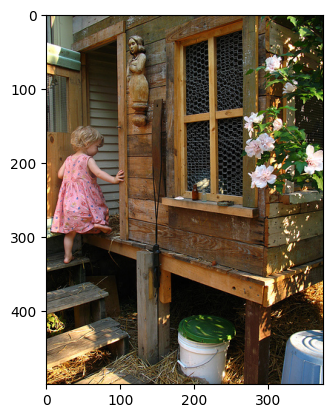

['a child in a pink dress is climbing up a set of stairs in an entry way ',
 'a girl going into a wooden building ',
 'a little girl climbing into a wooden playhouse ',
 'a little girl climbing the stairs to her playhouse ',
 'a little girl in a pink dress going into a wooden cabin ']

In [11]:
pic = '1000268201_693b08cb0e.jpg'
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()
descriptions['1000268201_693b08cb0e']

In [12]:
vocabulary = set()
for key in descriptions.keys():
        [vocabulary.update(d.split()) for d in descriptions[key]]
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8828


In [13]:
lines = list()
for key, desc_list in descriptions.items():
    for desc in desc_list:
        lines.append(key + ' ' + desc)
new_descriptions = '\n'.join(lines)

In [14]:
doc = open(train_images_path,'r').read()
dataset = list()
for line in doc.split('\n'):
    if len(line) > 1:
      identifier = line.split('.')[0]
      dataset.append(identifier)

train = set(dataset)

In [15]:
img = glob.glob(images_path + '*.jpg')
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))
train_img = []
for i in img:
    if i[len(images_path):] in train_images:
        train_img.append(i)

test_images = set(open(test_images_path, 'r').read().strip().split('\n'))
test_img = []
for i in img:
    if i[len(images_path):] in test_images:
        test_img.append(i)

In [16]:
train_descriptions = dict()
for line in new_descriptions.split('\n'):
    tokens = line.split()
    image_id, image_desc = tokens[0], tokens[1:]
    if image_id in train:
        if image_id not in train_descriptions:
            train_descriptions[image_id] = list()
        desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
        train_descriptions[image_id].append(desc)

In [17]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)

In [18]:
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

print('Vocabulary = %d' % (len(vocab)))

Vocabulary = 1659


In [19]:
ixtoword = {}
wordtoix = {}
ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1

In [20]:
all_desc = list()
for key in train_descriptions.keys():
    [all_desc.append(d) for d in train_descriptions[key]]
lines = all_desc
max_length = max(len(d.split()) for d in lines)

print('Description Length: %d' % max_length)

Description Length: 38


In [21]:
###GLOVE Embedding
embeddings_index = {}
f = open(os.path.join(glove_path, 'glove.6B.200d.txt'), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

In [22]:
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [23]:
model = InceptionV3(weights='imagenet')

96112376/96112376 [==============================] - 4s 0us/step


In [24]:
model_new = Model(model.input, model.layers[-2].output)

In [25]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [26]:
def encode(image):
    image = preprocess(image)
    fea_vec = model_new.predict(image)
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

encoding_train = {}
for img in train_img:
    encoding_train[img[len(images_path):]] = encode(img)
train_features = encoding_train

encoding_test = {}
for img in test_img:
    encoding_test[img[len(images_path):]] = encode(img)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 255ms/step


In [27]:
# Store the above computed features on the disk
# Use pickle to dump the entire data
import pickle

with open("encoded_train_features.pkl", "wb") as file:
    # Pickle allows to store any object as a file on the disk
    pickle.dump(encoding_train, file)

In [28]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 38)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 38, 200)      332000      ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

In [29]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [30]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [31]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n=0

In [32]:
epochs = 8
batch_size = 5
steps = len(train_descriptions)//batch_size

generator = data_generator(train_descriptions, train_features, wordtoix, max_length, batch_size)
model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)

Epoch 1/8
1200/1200 [==============================] - 1055s 874ms/step - loss: 3.7629 - accuracy: 0.2987
Epoch 2/8
1200/1200 [==============================] - 1053s 878ms/step - loss: 3.0767 - accuracy: 0.3573
Epoch 3/8
1200/1200 [==============================] - 1045s 871ms/step - loss: 2.8652 - accuracy: 0.3782
Epoch 4/8
1200/1200 [==============================] - 1045s 871ms/step - loss: 2.7404 - accuracy: 0.3897
Epoch 5/8
1200/1200 [==============================] - 1043s 869ms/step - loss: 2.6487 - accuracy: 0.3982
Epoch 6/8
1200/1200 [==============================] - 1043s 869ms/step - loss: 2.5767 - accuracy: 0.4057
Epoch 7/8
1200/1200 [==============================] - 1053s 877ms/step - loss: 2.5202 - accuracy: 0.4120
Epoch 8/8
1200/1200 [==============================] - 1057s 881ms/step - loss: 2.4745 - accuracy: 0.4166


In [33]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [34]:
def beam_search_predictions(image, beam_index = 3):
    start = [wordtoix["startseq"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = model.predict([image,par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])

        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]

    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]
    final_caption = []

    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

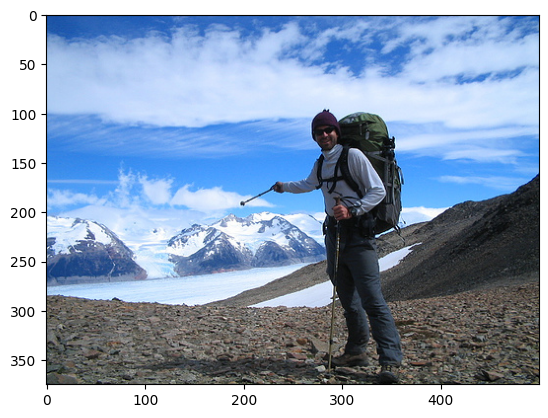

Greedy Search: a man is standing on top of a cliff overlooking the ocean
Beam Search, K = 3: a man is standing on top of a cliff overlooking the ocean
Beam Search, K = 5: a man is standing on top of a cliff overlooking the ocean
Beam Search, K = 7: a man is standing on top of a cliff overlooking the ocean
Beam Search, K = 10: a man is standing on top of a cliff overlooking the ocean


In [35]:
pic = '54501196_a9ac9d66f2.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

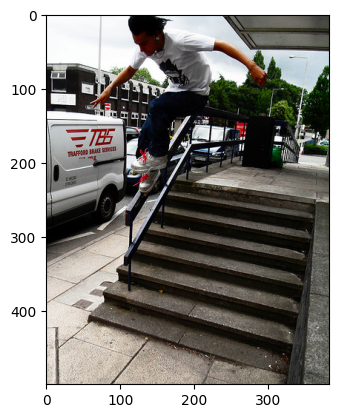

Greedy Search: a man is standing on a railing near a building
Beam Search, K = 3: a man in a red shirt is standing on a railing near a building
Beam Search, K = 5: a man wearing a red shirt is standing on a railing near a building
Beam Search, K = 7: a little boy in a red shirt is standing on a railing near a building
Beam Search, K = 10: a man does a trick on a sidewalk


In [57]:
pic = '3702436188_2c26192fd0.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

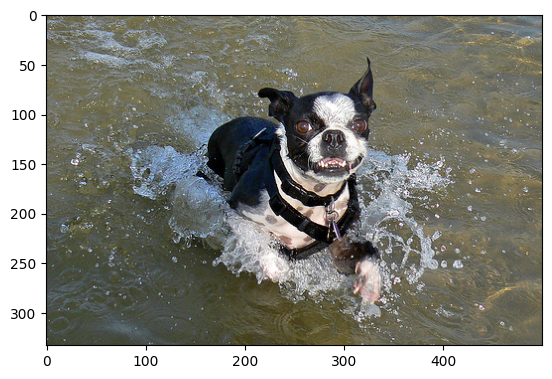

Greedy Search: a black dog is running through the water
Beam Search, K = 3: a black and white dog is running through the water
Beam Search, K = 5: a black and white dog with a stick in its mouth runs through the water
Beam Search, K = 7: a black and white dog with a stick in its mouth runs through the water
Beam Search, K = 10: a black and white dog with a ball in its mouth runs through the water


In [58]:
pic = '1772859261_236c09b861.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

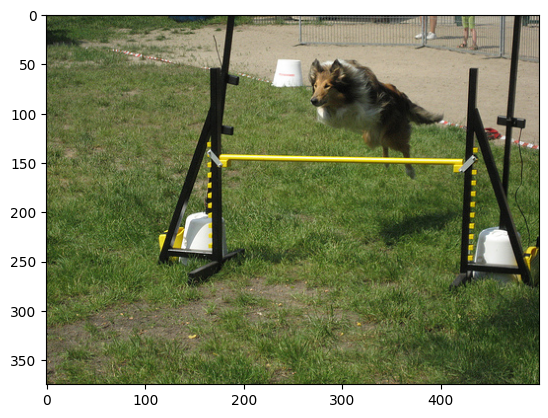

Greedy Search: a dog is running through a field of grass
Beam Search, K = 3: a black and white dog jumps over a red ball
Beam Search, K = 5: a black and white dog jumps over a red ball
Beam Search, K = 7: a black and white dog jumps over a red ball
Beam Search, K = 10: a black and white dog playing with a ball in his mouth


In [59]:
pic = '537559285_29be110134.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

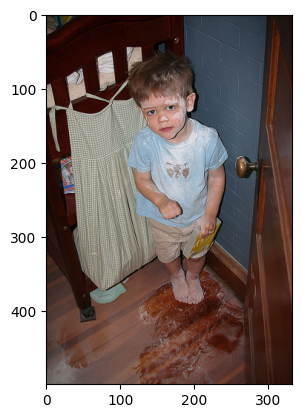

Greedy Search: a young boy is sitting on a bed with a red toy
Beam Search, K = 3: a young boy is sitting on a bed holding a stuffed animal
Beam Search, K = 5: a little boy is sitting on a bed
Beam Search, K = 7: a little boy is sitting on a bed
Beam Search, K = 10: a little boy is sitting on a bed


In [75]:
pic = '2706766641_a9df81969d.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

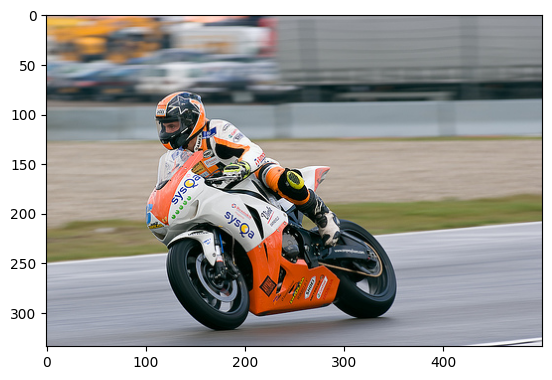

Greedy Search: a man in a red uniform is riding a motorcycle
Beam Search, K = 3: a man in a red uniform is riding a red motorcycle on a track
Beam Search, K = 5: this person is riding a red motorcycle
Beam Search, K = 7: there is a person on a motorcycle doing a wheelie on a racetrack
Beam Search, K = 10: there is a silver motorcycle racing on a racetrack


In [76]:
pic = '2739331794_4ae78f69a0.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

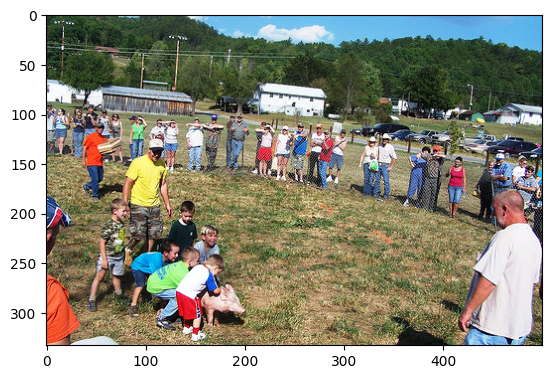

Greedy Search: a group of people are standing around a group of people and a man in a white shirt
Beam Search, K = 3: a group of people are standing in front of a group of birds
Beam Search, K = 5: a group of people are posing for a picture in front of a tree
Beam Search, K = 7: a group of people are posing for a picture in front of a white building
Beam Search, K = 10: a group of people are posing for a picture in front of a tent


In [67]:
pic = '1917265421_aeccf1ca38.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

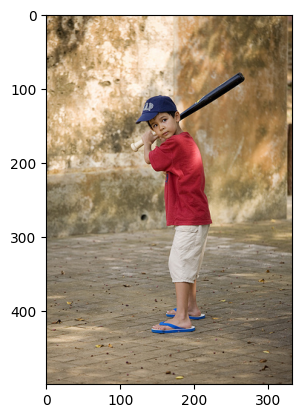

Greedy Search: a man in a black shirt is standing on a rock
Beam Search, K = 3: a young boy in a red shirt is running through a parking lot
Beam Search, K = 5: a young boy in a red shirt is running through a parking lot
Beam Search, K = 7: a young boy wearing a blue shirt is running through a parking lot
Beam Search, K = 10: a little boy in a red shirt is running through a parking lot


In [68]:
pic = '2774430374_fee1d793e7.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

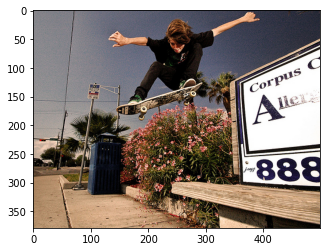

Greedy Search: a boy does a trick on a skateboard
Beam Search, K = 3: a young boy does a trick on a trampoline
Beam Search, K = 5: a young boy does a trick on a trampoline
Beam Search, K = 7: a young boy does a trick on a trampoline
Beam Search, K = 10: a boy doing a trick on a trampoline


In [ ]:
pic = '3708177171_529bb4ff1d.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

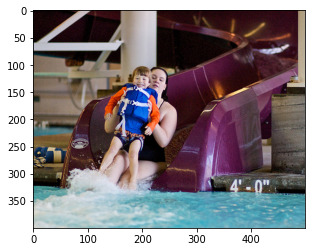

Greedy Search: a boy in a swimming pool flipping a swimming pool
Beam Search, K = 3: a young boy slides down a water slide into a pool
Beam Search, K = 5: a young boy slides down a water slide into a pool
Beam Search, K = 7: a little boy slides down a water slide into a pool
Beam Search, K = 10: a young boy slides down a water slide into a pool


In [ ]:
pic = '3030566410_393c36a6c5.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

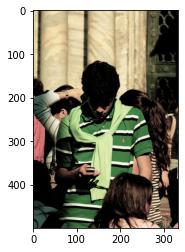

Greedy Search: a group of people are sitting in a line
Beam Search, K = 3: a group of people are sitting at a table in front of a crowd
Beam Search, K = 5: a group of people at a party
Beam Search, K = 7: a group of people at a party
Beam Search, K = 10: a group of people pose for a picture in front of a crowd


In [ ]:
pic = '421322723_3470543368.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

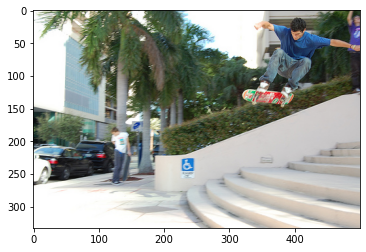

Greedy Search: a child is jumping off of a cement wall
Beam Search, K = 3: a young boy jumps off of a cement wall
Beam Search, K = 5: a little boy jumps off of a cement wall
Beam Search, K = 7: a child does a trick on a skateboard
Beam Search, K = 10: a child does a trick on a skateboard


In [ ]:
pic = '2306674172_dc07c7f847.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

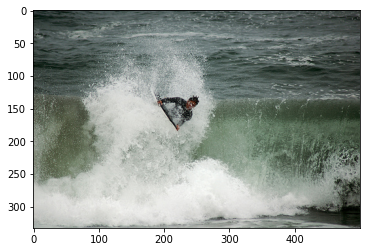

Greedy Search: a man is jumping into the water
Beam Search, K = 3: a man in a red wetsuit is surfing in the ocean
Beam Search, K = 5: a black dog jumping into the water
Beam Search, K = 7: a black dog jumping into the water
Beam Search, K = 10: a white dog is jumping into the water


In [ ]:
pic = '3631986552_944ea208fc.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

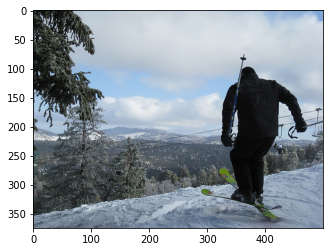

Greedy Search: a man is standing on a snowy mountain
Beam Search, K = 3: a man is standing on top of a snowy mountain
Beam Search, K = 5: a man is standing on top of a snowy mountain
Beam Search, K = 7: a man is standing on top of a snowy mountain
Beam Search, K = 10: a man is standing on top of a snowy mountain


In [ ]:
pic = '3139876823_859c7d7c23.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

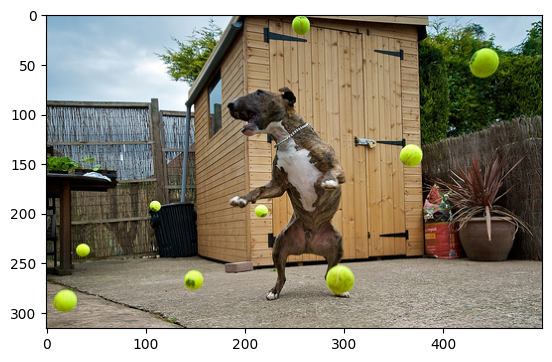

Greedy Search: a dog is jumping up to catch a frisbee
Beam Search, K = 3: a brown and white dog catches a tennis ball in his mouth
Beam Search, K = 5: a brown and white dog catches a tennis ball in his mouth
Beam Search, K = 7: a brown and white dog catches a tennis ball in his mouth
Beam Search, K = 10: a brown and white dog catches a tennis ball in his mouth


In [69]:
pic = '3490736665_38710f4b91.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

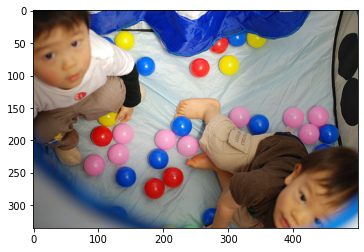

Greedy Search: a baby in a red shirt is playing with toys
Beam Search, K = 3: a baby in a red shirt plays with a toy in a house
Beam Search, K = 5: a baby in a red shirt lays on the floor surrounded by toys
Beam Search, K = 7: a little boy in a red shirt plays with a toy in a house
Beam Search, K = 10: a little boy in a red shirt plays with a toy in a house


In [ ]:
pic = '820169182_f5e78d7d19.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

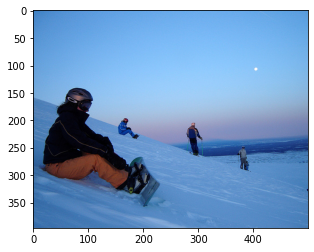

Greedy Search: a man in a red jacket is laying on a snowbank in the snow
Beam Search, K = 3: a group of people sit on a snowy hill
Beam Search, K = 5: a group of people play in the snow
Beam Search, K = 7: a group of people play in the snow in the snow
Beam Search, K = 10: a group of people play in the snow


In [ ]:
pic = '113678030_87a6a6e42e.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

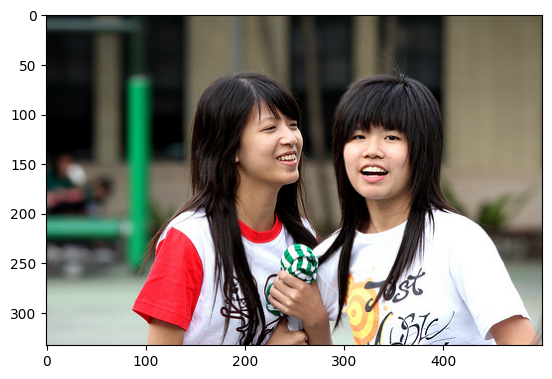

Greedy Search: a woman in a black shirt is standing by a woman in a black shirt
Beam Search, K = 3: a woman in a red shirt is standing in front of a bus
Beam Search, K = 5: a woman in a red shirt is talking to a woman in a red shirt
Beam Search, K = 7: a woman in a red shirt is standing next to a crowd of people
Beam Search, K = 10: a woman in a blue shirt is standing next to a crowd of people


In [70]:
pic = '3135504530_0f4130d8f8.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))